In [ ]:
# =============================================================================
# GMM (i.i.d.) baseline for HTTP: fit with EM, then sample per test flow
# =============================================================================
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# --------------------------- hyper-parameters ---------------------------
SEED              = 42
TEST_SIZE         = 0.25
N_MIX_GMM         = 12              # number of mixture components
COVARIANCE_TYPE   = "diag"          # "diag" or "full"
MAX_ITER_EM       = 500
TOL_EM            = 1e-4
REG_COVAR         = 1e-6            # small ridge for numerical stability

DATA_PATH = Path("real_data/df_raw_HTTP.csv")   # do not change

# ------------------------------- load data ------------------------------
df = pd.read_csv(DATA_PATH)
# expect at least these columns
required_cols = {"flow_id", "payload_length", "time_diff"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df = df[["flow_id", "payload_length", "time_diff"]].dropna()

# --------------------------- split by flow ids --------------------------
flow_ids = df["flow_id"].unique()
train_ids, test_ids = train_test_split(
    flow_ids, test_size=TEST_SIZE, random_state=SEED, shuffle=True
)

train_df = df[df.flow_id.isin(train_ids)].reset_index(drop=True)
test_df  = df[df.flow_id.isin(test_ids)].reset_index(drop=True)

# ------------------------- scale features (fit on train) ----------------
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[["payload_length", "time_diff"]].to_numpy())
X_test  = scaler.transform(test_df[["payload_length", "time_diff"]].to_numpy())

# ----------------------------- fit GMM (EM) -----------------------------
gmm = GaussianMixture(
    n_components=N_MIX_GMM,
    covariance_type=COVARIANCE_TYPE,
    max_iter=MAX_ITER_EM,
    tol=TOL_EM,
    reg_covar=REG_COVAR,
    random_state=SEED,
    init_params="kmeans",
    verbose=1
)
gmm.fit(X_train)

print(f"GMM converged: {gmm.converged_}  after {gmm.n_iter_} EM steps")
print(f"Train log-likelihood per sample: {gmm.score(X_train):.4f}")
print(f"AIC={gmm.aic(X_train):.1f}   BIC={gmm.bic(X_train):.1f}")

# ------------------------ per-flow synthetic sampling -------------------
# For a fair per-flow comparison we keep each test flow_id and
# generate the same number of packets for that flow, i.i.d. from the GMM.
records = []
rng = np.random.default_rng(SEED)

# bounds from the training set to avoid unrealistic extremes after inverse scaling
pl_min, pl_max = train_df["payload_length"].min(), train_df["payload_length"].max()
td_min, td_max = train_df["time_diff"].min(),      train_df["time_diff"].max()

for fid, grp in test_df.groupby("flow_id"):
    n = len(grp)
    # sample in standardized space, then invert scaling
    X_synth_std, _ = gmm.sample(n_samples=n)
    X_synth = scaler.inverse_transform(X_synth_std)

    # clip to nonnegative and to train-set range for stability
    pl = np.clip(X_synth[:, 0], 0.0, pl_max)
    td = np.clip(X_synth[:, 1], 0.0, td_max)

    # round payload to integers; keep time_diff as float
    pl = np.rint(pl).astype(int)

    records.append(pd.DataFrame({
        "flow_id": fid,
        "payload_length": pl,
        "time_diff": td
    }))

synth_df = pd.concat(records, ignore_index=True)

print("Synthetic set ready.")
print("test_df shape :", test_df.shape, "  unique flows:", test_df.flow_id.nunique())
print("synth_df shape:", synth_df.shape, "  unique flows:", synth_df.flow_id.nunique())


Initialization 0
  Iteration 10
  Iteration 20
Initialization converged.
GMM converged: True  after 22 EM steps
Train log-likelihood per sample: 8.0908
AIC=-121786.9   BIC=-121295.1
Synthetic set ready.
test_df shape : (2465, 3)   unique flows: 180
synth_df shape: (2465, 3)   unique flows: 180


KS  payload_length: D=0.2369  p=4.4637e-61
KS  time_diff     : D=0.3197  p=9.5469e-112


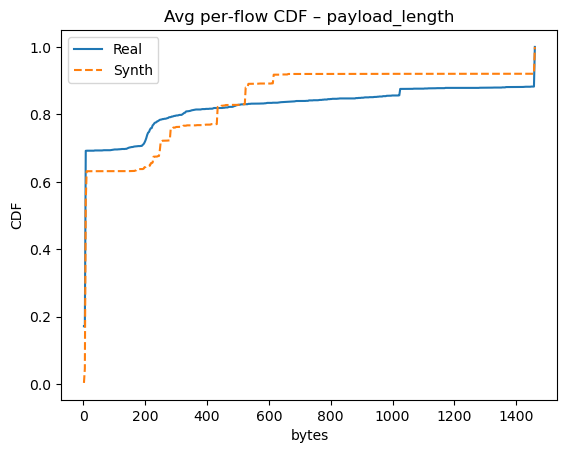

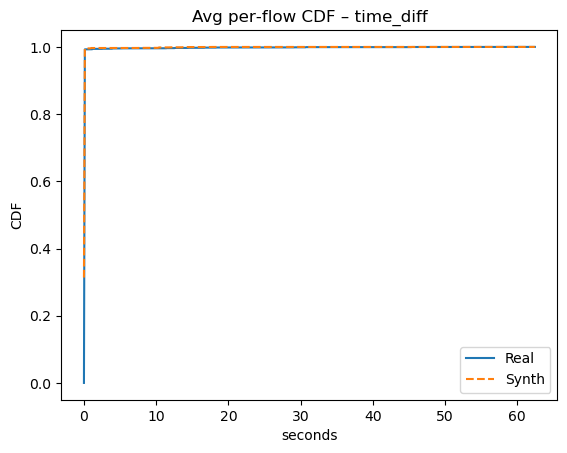

In [2]:
# ------------------------------------------------------------------ #
# 9  Sanity checks & CDF plots
# ------------------------------------------------------------------ #
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

stat_p, p_p = ks_2samp(test_df.payload_length, synth_df.payload_length)
stat_t, p_t = ks_2samp(test_df.time_diff,      synth_df.time_diff)
print(f"KS  payload_length: D={stat_p:.4f}  p={p_p:.4e}")
print(f"KS  time_diff     : D={stat_t:.4f}  p={p_t:.4e}")

def avg_flow_cdf(rdf, sdf, feat, grid=500):
    lo, hi = min(rdf[feat].min(), sdf[feat].min()), \
             max(rdf[feat].max(), sdf[feat].max())
    xs = np.linspace(lo, hi, grid)
    def cdfs(df):
        out = []
        for _, g in df.groupby("flow_id"):
            v = np.sort(g[feat].values)
            out.append(np.searchsorted(v, xs, 'right')/len(v))
        return np.stack(out)
    return xs, cdfs(rdf).mean(0), cdfs(sdf).mean(0)

x1, r1, s1 = avg_flow_cdf(test_df, synth_df, "payload_length")
x2, r2, s2 = avg_flow_cdf(test_df, synth_df, "time_diff")

plt.figure(); plt.plot(x1, r1, label="Real"); plt.plot(x1, s1, "--", label="Synth")
plt.title("Avg per‑flow CDF – payload_length"); plt.xlabel("bytes"); plt.ylabel("CDF")
plt.legend(); plt.show()

plt.figure(); plt.plot(x2, r2, label="Real"); plt.plot(x2, s2, "--", label="Synth")
plt.title("Avg per‑flow CDF – time_diff"); plt.xlabel("seconds"); plt.ylabel("CDF")
plt.legend(); plt.show()

/tmp/ipykernel_61824/3994907237.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_61824/3994907237.py:117: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ent_real, ent_synt], labels=['Real','Synthetic'], showfliers=False)
/tmp/ipykernel_61824/3994907237.py:117: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ent_real, ent_synt], labels=['Real','Synthetic'], showfliers=False)


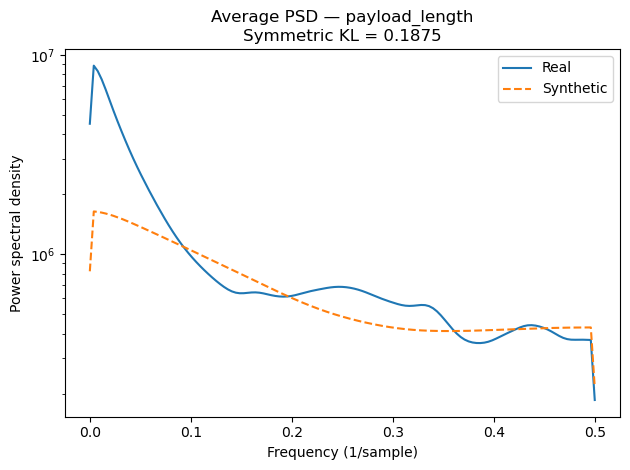

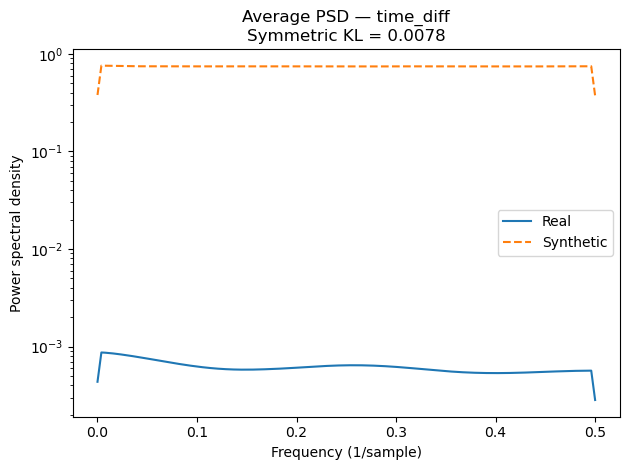

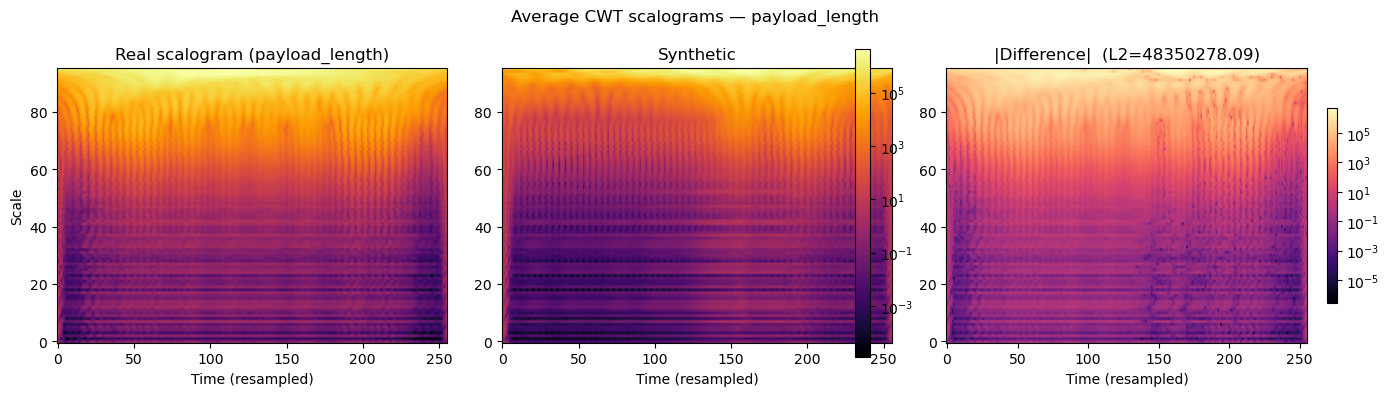

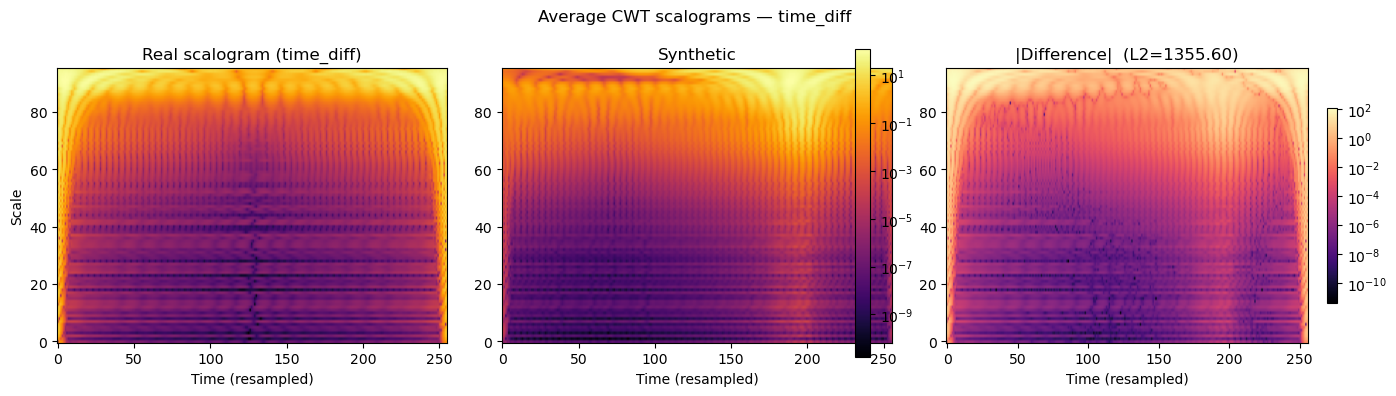

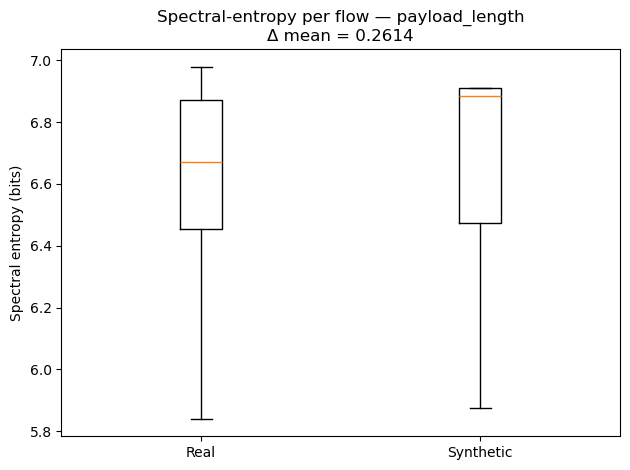

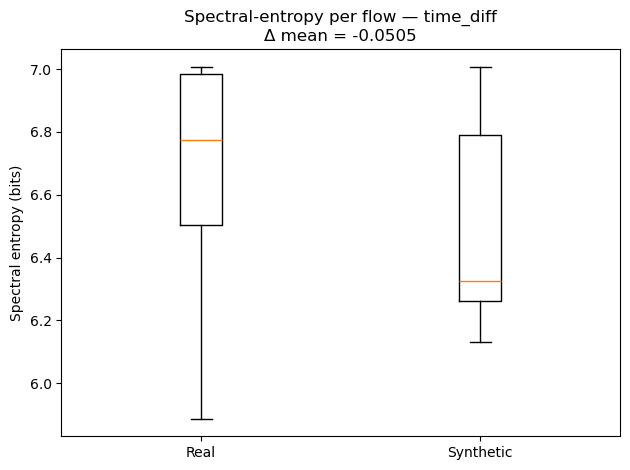

In [3]:
# ---------------------------------------------------------------
# 11. FREQUENCY & MULTI‑SCALE ANALYSIS
# ---------------------------------------------------------------
import scipy.signal as sg
from scipy.stats import entropy
import pywt
from sklearn.metrics import pairwise_distances
from matplotlib.colors import LogNorm

# ---------- helpers ------------------------------------------------
def sequences_by_flow(df, feature):
    """Return a list of 1‑D numpy arrays – one per flow."""
    return [
        grp.sort_index()[feature].values.astype(float)
        for _, grp in df.groupby('flow_id')
        if len(grp) > 1                                              # need ≥2 samples for FFT
    ]

def average_psd(seqs, fs=1.0, nfft=256):
    """Welch PSD on each seq, then mean across flows."""
    psds  = []
    freqs = None
    for x in seqs:
        f, p = sg.welch(x, fs=fs, nperseg=min(nfft, len(x)), nfft=nfft, scaling='density', detrend=False)
        psds.append(p + 1e-12)      # avoid zeros for KL
        if freqs is None:
            freqs = f
    return freqs, np.vstack(psds).mean(axis=0)

def kl_divergence(p, q):
    """Symmetric KL (Jensen–Shannon style)."""
    p_norm, q_norm = p / p.sum(), q / q.sum()
    return 0.5 * (entropy(p_norm, q_norm) + entropy(q_norm, p_norm))

def scalogram_energy(seq, wavelet='morl', voices_per_oct=16):
    """
    CWT scalogram (|coeff|**2) ‑‑> log‑scaled image of shape (scales, time_resampled)
    All sequences are resampled to LEN_TIME points for comparability.
    """
    LEN_TIME = 256
    seq_res  = sg.resample(seq, LEN_TIME)  # 1‑D resample
    widths   = pywt.scale2frequency(wavelet, [1])          # for reference
    max_scale = len(seq_res) // 2
    scales = pywt.frequency2scale(wavelet, np.linspace(0.5, 0.01, voices_per_oct*6))
    coeffs, _ = pywt.cwt(seq_res, scales, wavelet, method='fft')
    energy = np.abs(coeffs)**2
    return energy

def average_scalogram(seqs, **kwargs):
    scals = [scalogram_energy(x, **kwargs) for x in seqs]
    return np.stack(scals, axis=0).mean(axis=0)   # (scales, time)

# ---------- collect sequences ------------------------------------
real_payload_seqs = sequences_by_flow(test_df, 'payload_length')
synt_payload_seqs = sequences_by_flow(synth_df, 'payload_length')
real_time_seqs    = sequences_by_flow(test_df, 'time_diff')
synt_time_seqs    = sequences_by_flow(synth_df, 'time_diff')

# ---------- (A) Power‑spectral density & KL ----------------------
for name, real_s, synt_s in [('payload_length', real_payload_seqs, synt_payload_seqs),
                             ('time_diff',      real_time_seqs,    synt_time_seqs)]:
    f, psd_real = average_psd(real_s)
    _, psd_synt = average_psd(synt_s)
    d_kl = kl_divergence(psd_real, psd_synt)

    plt.figure()
    plt.semilogy(f, psd_real,  label='Real')
    plt.semilogy(f, psd_synt,  '--', label='Synthetic')
    plt.xlabel('Frequency (1/sample)')
    plt.ylabel('Power spectral density')
    plt.title(f'Average PSD — {name}\nSymmetric KL = {d_kl:.4f}')
    plt.legend()
    plt.tight_layout()

# ---------- (B) Wavelet scalogram & L2 distance -------------------
for name, real_s, synt_s in [('payload_length', real_payload_seqs, synt_payload_seqs),
                             ('time_diff',      real_time_seqs,    synt_time_seqs)]:
    scal_real = average_scalogram(real_s)
    scal_synt = average_scalogram(synt_s)
    l2_dist   = np.linalg.norm(scal_real - scal_synt)

    fig, axs = plt.subplots(1, 3, figsize=(14,4))
    im0 = axs[0].imshow(scal_real, aspect='auto', origin='lower',
                        norm=LogNorm(), cmap='inferno')
    axs[0].set_title(f'Real scalogram ({name})')
    im1 = axs[1].imshow(scal_synt, aspect='auto', origin='lower',
                        norm=LogNorm(), cmap='inferno')
    axs[1].set_title('Synthetic')
    diff = scal_real - scal_synt
    im2 = axs[2].imshow(np.abs(diff), aspect='auto', origin='lower',
                        norm=LogNorm(), cmap='magma')
    axs[2].set_title(f'|Difference|  (L2={l2_dist:.2f})')
    for ax in axs: ax.set_xlabel('Time (resampled)')
    axs[0].set_ylabel('Scale')
    fig.colorbar(im0, ax=axs[:2], fraction=0.025)
    fig.colorbar(im2, ax=axs[2],  fraction=0.025)
    fig.suptitle(f'Average CWT scalograms — {name}')
    plt.tight_layout()

# ---------- (C) Spectral entropy distributions --------------------
def spectral_entropy_list(seqs):
    entropies = []
    for x in seqs:
        f, p = sg.welch(x, nperseg=min(256, len(x)), nfft=256, scaling='density', detrend=False)
        p_norm = p / p.sum()
        entropies.append(entropy(p_norm, base=2))
    return np.array(entropies)

results = {}
for name, real_s, synt_s in [('payload_length', real_payload_seqs, synt_payload_seqs),
                             ('time_diff',      real_time_seqs,    synt_time_seqs)]:
    ent_real = spectral_entropy_list(real_s)
    ent_synt = spectral_entropy_list(synt_s)
    results[name] = (ent_real, ent_synt)

    plt.figure()
    plt.boxplot([ent_real, ent_synt], labels=['Real','Synthetic'], showfliers=False)
    plt.ylabel('Spectral entropy (bits)')
    plt.title(f'Spectral‑entropy per flow — {name}\nΔ mean = {ent_synt.mean() - ent_real.mean():.4f}')
    plt.tight_layout()

plt.show()


In [4]:
from statsmodels.tsa.stattools import acf

def seqs_by_flow(df: pd.DataFrame, col: str):
    return [g.sort_index()[col].astype(float).values
            for _, g in df.groupby("flow_id") if len(g) > 1]

def average_psd(seqs, fs: float = 1.0, nfft: int = 256):
    psds = []
    freqs = None
    for x in seqs:
        f, p = sg.welch(x, fs=fs, nperseg=min(nfft, len(x)), nfft=nfft,
                         scaling="density", detrend=False)
        psds.append(p + 1e-12)  # avoid zeros
        if freqs is None:
            freqs = f
    return freqs, np.mean(psds, axis=0)

def kl_div(p, q):
    p, q = p / p.sum(), q / q.sum()
    return 0.5 * (entropy(p, q) + entropy(q, p))

# --- average CDF per flow ----------------------------------------------------
def avg_flow_cdf(rdf, sdf, feat, grid=500):
    lo, hi = min(rdf[feat].min(), sdf[feat].min()), \
             max(rdf[feat].max(), sdf[feat].max())
    xs = np.linspace(lo, hi, grid)

    def _flow_cdfs(df):
        mats = []
        for _, g in df.groupby('flow_id'):
            v = np.sort(g[feat].values)
            mats.append(np.searchsorted(v, xs, 'right') / len(v))
        return np.stack(mats)                 # (n_flows, grid)

    return xs, _flow_cdfs(rdf).mean(0), _flow_cdfs(sdf).mean(0)

# KL between the two *mean* CDFs (convert CDF→PDF via finite diff)
def kl_avg_flow_cdf(rdf, sdf, feat, grid=500):
    _, cdf_r, cdf_s = avg_flow_cdf(rdf, sdf, feat, grid)
    pdf_r = np.diff(cdf_r, prepend=0) + 1e-12   # avoid zeros
    pdf_s = np.diff(cdf_s, prepend=0) + 1e-12
    return kl_div(pdf_r, pdf_s)

def spectral_entropy_list(seqs, nfft: int = 256):
    ent = []
    for x in seqs:
        _, Pxx = sg.welch(x, nperseg=min(nfft, len(x)), nfft=nfft,
                          scaling="density")
        Pxx /= Pxx.sum()
        ent.append(entropy(Pxx, base=2))
    return np.asarray(ent)

def spectral_entropy_coverage(real, synth):
    def _e(v):
        _, P = sg.welch(v, nperseg=min(256, len(v)), nfft=256, scaling="density")
        P /= P.sum()
        return entropy(P, base=2)
    H_r = np.array([_e(x) for x in real])
    H_s = np.array([_e(x) for x in synth])
    cov = max(0, H_s.min() - H_r.min()) + max(0, H_r.max() - H_s.max())
    return cov / (H_r.max() - H_r.min() + 1e-12)

def mean_acf(seqs, nlags=20, fft=True):
    """
    Element-wise mean ACF over a list of 1-D sequences.

    • If a sequence is shorter than `nlags+1`, we let acf() return the
      maximum it can (len(x) lags).
    • After collecting all ACFs, we truncate every vector to the *shortest*
      length found, so we have a neat (n_flows, L) matrix.
    """
    acfs = []
    for x in seqs:
        if len(x) < 2:
            continue                      # needs at least 2 points
        L = min(nlags, len(x) - 1)
        acfs.append(acf(x, nlags=L, fft=fft))

    if not acfs:
        raise ValueError("No sequences long enough to compute ACF")

    # truncate to common length
    Lmin = min(a.size for a in acfs)
    acfs = np.stack([a[:Lmin] for a in acfs])
    return acfs.mean(axis=0)


metrics = {}
metrics["ks_payload"] = ks_2samp(test_df.payload_length, synth_df.payload_length).statistic
metrics["ks_time"]    = ks_2samp(test_df.time_diff,      synth_df.time_diff).statistic

rp, psd_r = average_psd(seqs_by_flow(test_df, "payload_length"))
_,  psd_s = average_psd(seqs_by_flow(synth_df, "payload_length"))
metrics["kl_psd_payload"] = kl_div(psd_r, psd_s)

rt, tpd_r = average_psd(seqs_by_flow(test_df, "time_diff"))
_,  tpd_s = average_psd(seqs_by_flow(synth_df, "time_diff"))
metrics["kl_psd_time"] = kl_div(tpd_r, tpd_s)

metrics['kl_cdf_payload'] = kl_avg_flow_cdf(test_df,   synth_df, 'payload_length')
metrics['kl_cdf_time']    = kl_avg_flow_cdf(test_df,   synth_df, 'time_diff')

metrics["diversity_payload"] = spectral_entropy_coverage(
    seqs_by_flow(test_df, "payload_length"), seqs_by_flow(synth_df, "payload_length"))
metrics["diversity_time"] = spectral_entropy_coverage(
    seqs_by_flow(test_df, "time_diff"), seqs_by_flow(synth_df, "time_diff"))

ent_real_pl = spectral_entropy_list(seqs_by_flow(test_df, "payload_length"))
ent_synt_pl = spectral_entropy_list(seqs_by_flow(synth_df, "payload_length"))
metrics["delta_mean_payload"] = float(abs(ent_synt_pl.mean() - ent_real_pl.mean()))

ent_real_td = spectral_entropy_list(seqs_by_flow(test_df, "time_diff"))
ent_synt_td = spectral_entropy_list(seqs_by_flow(synth_df, "time_diff"))
metrics["delta_mean_time"] = float(abs(ent_synt_td.mean() - ent_real_td.mean()))

acf_r_payload = mean_acf(seqs_by_flow(test_df,  "payload_length"))
acf_s_payload = mean_acf(seqs_by_flow(synth_df, "payload_length"))
L = min(len(acf_r_payload), len(acf_s_payload))    
metrics['acf_rmse_payload'] = np.sqrt(
    ((acf_r_payload[:L] - acf_s_payload[:L]) ** 2).mean())

acf_r_time = mean_acf(seqs_by_flow(test_df,  "time_diff"))
acf_s_time = mean_acf(seqs_by_flow(synth_df, "time_diff"))
L = min(len(acf_r_time), len(acf_s_time))
metrics['acf_rmse_time'] = np.sqrt(
    ((acf_r_time[:L] - acf_s_time[:L]) ** 2).mean())

# --- print metrics -----------------------------------------------------------
print("\n=== Metrics - HTTP ===")
for k, v in metrics.items():
    print(f"{k:<25} : {v:.4g}")


=== Metrics - HTTP ===
ks_payload                : 0.2369
ks_time                   : 0.3197
kl_psd_payload            : 0.1875
kl_psd_time               : 0.007822
kl_cdf_payload            : 4.588
kl_cdf_time               : 4.325
diversity_payload         : 0.02826
diversity_time            : 0.7669
delta_mean_payload        : 0.02831
delta_mean_time           : 0.02855
acf_rmse_payload          : 0.1181
acf_rmse_time             : 0.1436


In [5]:
# New cell: per-flow shuffle control (destroys all within-flow temporal structure)
import numpy as np, pandas as pd
rng = np.random.default_rng(42)

shuf = []
for fid, grp in test_df.groupby("flow_id", sort=False):
    g = grp.copy()
    g["payload_length"] = rng.permutation(g["payload_length"].to_numpy())
    g["time_diff"]      = rng.permutation(g["time_diff"].to_numpy())
    shuf.append(g)
synth_df_shuffled = pd.concat(shuf, ignore_index=True)

print("shuffled control ready:", synth_df_shuffled.shape, "flows:", synth_df_shuffled.flow_id.nunique())


shuffled control ready: (2465, 3) flows: 180


In [6]:
from statsmodels.tsa.stattools import acf

def seqs_by_flow(df: pd.DataFrame, col: str):
    return [g.sort_index()[col].astype(float).values
            for _, g in df.groupby("flow_id") if len(g) > 1]

def average_psd(seqs, fs: float = 1.0, nfft: int = 256):
    psds = []
    freqs = None
    for x in seqs:
        f, p = sg.welch(x, fs=fs, nperseg=min(nfft, len(x)), nfft=nfft,
                         scaling="density", detrend=False)
        psds.append(p + 1e-12)  # avoid zeros
        if freqs is None:
            freqs = f
    return freqs, np.mean(psds, axis=0)

def kl_div(p, q):
    p, q = p / p.sum(), q / q.sum()
    return 0.5 * (entropy(p, q) + entropy(q, p))

# --- average CDF per flow ----------------------------------------------------
def avg_flow_cdf(rdf, sdf, feat, grid=500):
    lo, hi = min(rdf[feat].min(), sdf[feat].min()), \
             max(rdf[feat].max(), sdf[feat].max())
    xs = np.linspace(lo, hi, grid)

    def _flow_cdfs(df):
        mats = []
        for _, g in df.groupby('flow_id'):
            v = np.sort(g[feat].values)
            mats.append(np.searchsorted(v, xs, 'right') / len(v))
        return np.stack(mats)                 # (n_flows, grid)

    return xs, _flow_cdfs(rdf).mean(0), _flow_cdfs(sdf).mean(0)

# KL between the two *mean* CDFs (convert CDF→PDF via finite diff)
def kl_avg_flow_cdf(rdf, sdf, feat, grid=500):
    _, cdf_r, cdf_s = avg_flow_cdf(rdf, sdf, feat, grid)
    pdf_r = np.diff(cdf_r, prepend=0) + 1e-12   # avoid zeros
    pdf_s = np.diff(cdf_s, prepend=0) + 1e-12
    return kl_div(pdf_r, pdf_s)

def spectral_entropy_list(seqs, nfft: int = 256):
    ent = []
    for x in seqs:
        _, Pxx = sg.welch(x, nperseg=min(nfft, len(x)), nfft=nfft,
                          scaling="density")
        Pxx /= Pxx.sum()
        ent.append(entropy(Pxx, base=2))
    return np.asarray(ent)

def spectral_entropy_coverage(real, synth):
    def _e(v):
        _, P = sg.welch(v, nperseg=min(256, len(v)), nfft=256, scaling="density")
        P /= P.sum()
        return entropy(P, base=2)
    H_r = np.array([_e(x) for x in real])
    H_s = np.array([_e(x) for x in synth])
    cov = max(0, H_s.min() - H_r.min()) + max(0, H_r.max() - H_s.max())
    return cov / (H_r.max() - H_r.min() + 1e-12)

def mean_acf(seqs, nlags=20, fft=True):
    """
    Element-wise mean ACF over a list of 1-D sequences.

    • If a sequence is shorter than `nlags+1`, we let acf() return the
      maximum it can (len(x) lags).
    • After collecting all ACFs, we truncate every vector to the *shortest*
      length found, so we have a neat (n_flows, L) matrix.
    """
    acfs = []
    for x in seqs:
        if len(x) < 2:
            continue                      # needs at least 2 points
        L = min(nlags, len(x) - 1)
        acfs.append(acf(x, nlags=L, fft=fft))

    if not acfs:
        raise ValueError("No sequences long enough to compute ACF")

    # truncate to common length
    Lmin = min(a.size for a in acfs)
    acfs = np.stack([a[:Lmin] for a in acfs])
    return acfs.mean(axis=0)


metrics = {}
metrics["ks_payload"] = ks_2samp(test_df.payload_length, synth_df_shuffled.payload_length).statistic
metrics["ks_time"]    = ks_2samp(test_df.time_diff,      synth_df_shuffled.time_diff).statistic

rp, psd_r = average_psd(seqs_by_flow(test_df, "payload_length"))
_,  psd_s = average_psd(seqs_by_flow(synth_df_shuffled, "payload_length"))
metrics["kl_psd_payload"] = kl_div(psd_r, psd_s)

rt, tpd_r = average_psd(seqs_by_flow(test_df, "time_diff"))
_,  tpd_s = average_psd(seqs_by_flow(synth_df_shuffled, "time_diff"))
metrics["kl_psd_time"] = kl_div(tpd_r, tpd_s)

metrics['kl_cdf_payload'] = kl_avg_flow_cdf(test_df,   synth_df_shuffled, 'payload_length')
metrics['kl_cdf_time']    = kl_avg_flow_cdf(test_df,   synth_df_shuffled, 'time_diff')

metrics["diversity_payload"] = spectral_entropy_coverage(
    seqs_by_flow(test_df, "payload_length"), seqs_by_flow(synth_df_shuffled, "payload_length"))
metrics["diversity_time"] = spectral_entropy_coverage(
    seqs_by_flow(test_df, "time_diff"), seqs_by_flow(synth_df_shuffled, "time_diff"))

ent_real_pl = spectral_entropy_list(seqs_by_flow(test_df, "payload_length"))
ent_synt_pl = spectral_entropy_list(seqs_by_flow(synth_df_shuffled, "payload_length"))
metrics["delta_mean_payload"] = float(abs(ent_synt_pl.mean() - ent_real_pl.mean()))

ent_real_td = spectral_entropy_list(seqs_by_flow(test_df, "time_diff"))
ent_synt_td = spectral_entropy_list(seqs_by_flow(synth_df_shuffled, "time_diff"))
metrics["delta_mean_time"] = float(abs(ent_synt_td.mean() - ent_real_td.mean()))

acf_r_payload = mean_acf(seqs_by_flow(test_df,  "payload_length"))
acf_s_payload = mean_acf(seqs_by_flow(synth_df_shuffled, "payload_length"))
L = min(len(acf_r_payload), len(acf_s_payload))    
metrics['acf_rmse_payload'] = np.sqrt(
    ((acf_r_payload[:L] - acf_s_payload[:L]) ** 2).mean())

acf_r_time = mean_acf(seqs_by_flow(test_df,  "time_diff"))
acf_s_time = mean_acf(seqs_by_flow(synth_df_shuffled, "time_diff"))
L = min(len(acf_r_time), len(acf_s_time))
metrics['acf_rmse_time'] = np.sqrt(
    ((acf_r_time[:L] - acf_s_time[:L]) ** 2).mean())

# --- print metrics -----------------------------------------------------------
print("\n=== Metrics - HTTP ===")
for k, v in metrics.items():
    print(f"{k:<25} : {v:.4g}")


=== Metrics - HTTP ===
ks_payload                : 0
ks_time                   : 0
kl_psd_payload            : 0.03517
kl_psd_time               : 0.007975
kl_cdf_payload            : 0
kl_cdf_time               : 0
diversity_payload         : 0.01297
diversity_time            : 0.005324
delta_mean_payload        : 0.2008
delta_mean_time           : 0.1499
acf_rmse_payload          : 0.09921
acf_rmse_time             : 0.05332


In [7]:
# dataset-level means
print(test_df[['payload_length','time_diff']].mean())
print(synth_df_shuffled[['payload_length','time_diff']].mean())

# per-flow mean diffs should be all zeros (up to float noise)
m_real  = test_df.groupby('flow_id')[['payload_length','time_diff']].mean().sort_index()
m_shuf  = synth_df_shuffled.groupby('flow_id')[['payload_length','time_diff']].mean().sort_index()
print((m_real - m_shuf).abs().describe())


payload_length    388.351318
time_diff           0.129003
dtype: float64
payload_length    388.351318
time_diff           0.129003
dtype: float64
       payload_length     time_diff
count           180.0  1.800000e+02
mean              0.0  2.650272e-19
std               0.0  2.087872e-18
min               0.0  0.000000e+00
25%               0.0  0.000000e+00
50%               0.0  0.000000e+00
75%               0.0  0.000000e+00
max               0.0  2.775558e-17
